<a href="https://colab.research.google.com/github/afrojaakter/FallResearch/blob/main/clas6_masked.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

####RNN

In [1]:
# Numpy, JAX, Matplotlib and h5py should all be correctly installed and on the python path.
from __future__ import print_function, division, absolute_import
import datetime
import h5py
import jax.numpy as np
from jax import grad, jit, lax, random, vmap
from jax.experimental import optimizers
import matplotlib.pyplot as plt
import numpy as onp             # original CPU-backed NumPy
import os
import sys
import time
from importlib import reload
from functools import partial

In [2]:
"""Vanilla RNN functions for init, definition and running."""
MAX_SEED_INT = 10000000

'''def random_vrnn_params(key, u, n, o, g=1.0):
  """Generate random RNN parameters"""

  key, skeys = keygen(key, 4)
  hscale = 0.1
  ifactor = 1.0 / np.sqrt(u)
  hfactor = g / np.sqrt(n)
  pfactor = 1.0 / np.sqrt(n)
  return {'h0' : random.normal(next(skeys), (n,)) * hscale,
          'wI' : random.normal(next(skeys), (n,u)) * ifactor,
          'wR' : random.normal(next(skeys), (n,n)) *  hfactor,
          'wO' : random.normal(next(skeys), (o,n)) * pfactor,
          'bR' : np.zeros([n]),
          'bO' : np.zeros([o])}'''
def random_vrnn_params(key, u, n, o, g=1.0):
  """Generate random RNN parameters"""

  key, skeys = keygen(key, 4)
  hscale = 0.1
  ifactor = 1.0 / np.sqrt(u)
  hfactor = g / np.sqrt(n)
  pfactor = 1.0 / np.sqrt(n)
  weight_dic = {}
  weight_dic['h0'] = random.normal(next(skeys), (n,)) * hscale
  MAX_SEED_INT = 10000001
  weight_dic['wI'] = random.normal(next(skeys), (n,u)) * ifactor
  weight_dic['wR'] = random.normal(next(skeys), (n,n)) *  hfactor
  weight_dic['wO'] = random.normal(next(skeys), (o,n)) * pfactor
  weight_dic['bR'] = np.zeros([n])
  weight_dic['bO'] = np.zeros([o])
  return weight_dic


def affine(params, x):
  """Implement y = w x + b"""
  return np.dot(params['wO'], x) + params['bO']

batch_affine = vmap(affine, in_axes=(None, 0))

def vrnn(params, h, x):
  """Run the Vanilla RNN one step"""
  a = np.dot(params['wI'], x) + params['bR'] + np.dot(params['wR'], h)
  return np.tanh(a)

def vrnn_scan(params, h, x):
  """Run the Vanilla RNN one step, returning (h ,h)."""  
  h = vrnn(params, h, x)
  return h, h

def vrnn_run_with_h0(params, x_t, h0):
  """Run the Vanilla RNN T steps, where T is shape[0] of input."""
  h = h0
  f = partial(vrnn_scan, params)
  _, h_t = lax.scan(f, h, x_t)
  o_t = batch_affine(params, h_t)
  return h_t, o_t

def vrnn_run(params, x_t):
  """Run the Vanilla RNN T steps, where T is shape[0] of input."""
  return vrnn_run_with_h0(params, x_t, params['h0'])
  
# Let's upgrade it to handle batches using `vmap`
# Make a batched version of the `predict` function
batched_rnn_run = vmap(vrnn_run, in_axes=(None, 0))
batched_rnn_run_w_h0 = vmap(vrnn_run_with_h0, in_axes=(None, 0, 0))
  
def loss(params, inputs_bxtxu, targets_bxtxo, targets_mask_t, l2reg):
  """Compute the least squares loss of the output, plus L2 regularization."""
  _, outs_bxtxo = batched_rnn_run(params, inputs_bxtxu)
  l2_loss = l2reg * optimizers.l2_norm(params)**2
  outs_bxsxo = outs_bxtxo[:, targets_mask_t, :]
  targets_bxsxo = targets_bxtxo[:, targets_mask_t, :]
  lms_loss = np.mean((outs_bxtxo - targets_bxtxo)**2)
  total_loss = lms_loss + l2_loss
  return {'total' : total_loss, 'lms' : lms_loss, 'l2' : l2_loss}

def update_w_gc(i, opt_state, opt_update, get_params, x_bxt, f_bxt,
                f_mask_bxt, max_grad_norm, l2reg):
  """Update the parameters w/ gradient clipped, gradient descent updates."""
  params = get_params(opt_state)

  def training_loss(params, x_bxt, f_bxt, l2reg):
    return loss(params, x_bxt, f_bxt, f_mask_bxt, l2reg)['total']
  
  grads = grad(training_loss)(params, x_bxt, f_bxt, l2reg)
  clipped_grads = optimizers.clip_grads(grads, max_grad_norm)
  return opt_update(i, clipped_grads, opt_state)

loss_jit = jit(loss)
update_w_gc_jit = jit(update_w_gc, static_argnums=(2,3))

def run_trials(batched_run_fun, inputs_targets_h0s_fun, nbatches, batch_size):
  """Run a bunch of trials and save everything in a dictionary."""
  inputs = []
  hiddens = []
  outputs = []
  targets = []
  h0s = []
  for n in range(nbatches):
    data_seeds = onp.random.randint(0, MAX_SEED_INT, size=batch_size)
    keys = np.array([random.PRNGKey(ds) for ds in data_seeds])
    input_b, target_b, masks_b, h0s_b = inputs_targets_h0s_fun(keys)
    if h0s_b is None:
      h_b, o_b = batched_run_fun(input_b)
    else:
      h_b, o_b = batched_run_fun(input_b, h0s_b)      
      h0s.append(h0s_b)
      
    inputs.append(input_b)
    hiddens.append(h_b)
    outputs.append(o_b)
    targets.append(target_b)
    
  trial_dict = {'inputs' : onp.vstack(inputs), 'hiddens' : onp.vstack(hiddens),
                'outputs' : onp.vstack(outputs), 'targets' : onp.vstack(targets)}
  if h0s_b is not None:
    trial_dict['h0s'] = onp.vstack(h0s)
  else:
    trial_dict['h0s'] = None
  return trial_dict


def plot_params(params):
  """ Plot the parameters of the vanilla RNN. """
  plt.figure(figsize=(16,8))
  plt.subplot(231)
  plt.stem(params['wO'][0,:])
  plt.title('wO - output weights')
  
  plt.subplot(232)
  plt.stem(params['h0'])
  plt.title('h0 - initial hidden state')
  
  plt.subplot(233)
  plt.imshow(params['wR'], interpolation=None)
  plt.title('wR - recurrent weights')
  plt.colorbar()
  
  plt.subplot(234)
  plt.stem(params['wI'])
  plt.title('wI - input weights')
  
  plt.subplot(235)
  plt.stem(params['bR'])
  plt.title('bR - recurrent biases')
  '''
  plt.subplot(236)
  evals, _ = onp.linalg.eig(params['wR'])
  x = onp.linspace(-1, 1, 1000)
  plt.plot(x, onp.sqrt(1-x**2), 'k')
  plt.plot(x, -onp.sqrt(1-x**2), 'k')
  plt.plot(onp.real(evals), onp.imag(evals), '.')
  plt.axis('equal')
  plt.title('Eigenvalues of wR')
  '''
  
def plot_examples(ntimesteps, rnn_internals, nexamples=1):
  """Plot some input/hidden/output triplets."""
  plt.figure(figsize=(nexamples*5, 12))
  for bidx in range(nexamples):
    plt.subplot(3, nexamples, bidx+1)
    plt.plot(rnn_internals['inputs'][bidx,:], 'k')
    plt.xlim([0, ntimesteps])
    plt.title('Example %d' % (bidx))
    if bidx == 0:
      plt.ylabel('Input')
      
  ntoplot = 10
  '''closeness = 0.25
  for bidx in range(nexamples):
    plt.subplot(3, nexamples, nexamples+bidx+1)
    plt.plot(rnn_internals['hiddens'][bidx, :, 0:ntoplot] +
             closeness * onp.arange(ntoplot), 'b')
    plt.xlim([0, ntimesteps])
    if bidx == 0:
      plt.ylabel('Hidden Units')'''
  for bidx in range(nexamples):
    plt.subplot(3, nexamples, nexamples+bidx+1)
    heatmap = plt.imshow(rnn_internals['hiddens'][bidx, :, :].T, origin = 'lower', aspect= 'auto')
    cbar = plt.colorbar(heatmap, orientation='horizontal') 
    if bidx == 0:
      plt.ylabel('Hidden Units')
      
  for bidx in range(nexamples):
    plt.subplot(3, nexamples, 2*nexamples+bidx+1)
    plt.plot(rnn_internals['outputs'][bidx,:,:], 'r')
    plt.plot(rnn_internals['targets'][bidx,:,:], 'k')    
    plt.xlim([0, ntimesteps])
    plt.xlabel('Timesteps')
    if bidx == 0:
      plt.ylabel('Output')

In [3]:
def keygen(key, nkeys):
  """Generate randomness that JAX can use by splitting the JAX keys.
  Args:
    key : the random.PRNGKey for JAX
    nkeys : how many keys in key generator
  Returns:
    2-tuple (new key for further generators, key generator)
  """
  keys = random.split(key, nkeys+1)
  return keys[0], (k for k in keys[1:])

####Integrator

In [66]:
"""Routines for creating white noise and integrated white noise."""
def build_input_and_target_pure_integration1(input_params, key):
  initial_constant = np.zeros(5)
  bias_val, stddev_val, T, Ntime = input_params
  dt = T/Ntime
  ntime = int(Ntime/4)

  # Create the white noise input.
  key, skeys = keygen(key, 2)
  random_sample = random.normal(next(skeys), (1,))[0]
  bias = bias_val * 2.0 * (random_sample - 0.5)
  stddev = stddev_val / np.sqrt(dt)
  random_samples = random.normal(next(skeys), (ntime,))
  noise_t = stddev * random_samples
  white_noise_t = bias + noise_t
  white_noise_t = np.pad(white_noise_t, (0, 3*ntime), 'constant')

  pure_integration_t = np.cumsum(white_noise_t)
  decision = 2.0*((pure_integration_t[24] > 0.0)-0.5)
  targets_t1 = np.zeros(pure_integration_t.shape[0])
  targets_t2 = np.ones(pure_integration_t.shape[0])
  targets_t = np.concatenate([targets_t1[:ntime-1],
                              np.array([decision], dtype=float), decision*targets_t2[ntime:]], axis=0)
  
  inputs_tx1 = np.expand_dims(white_noise_t, axis=1)
  targets_tx1 = np.expand_dims(targets_t, axis=1)
  target_mask = np.array([ntime-1]) # When target is defined.
  print('targetMask', target_mask)
  return inputs_tx1, targets_tx1, target_mask

def build_input_and_target_pure_integration2(input_params, key):
  bias_val, stddev_val, T, ntime = input_params
  dt = T/ntime
  ntime = int(2*ntime/4)
  # Create the white noise input.
  key, skeys = keygen(key, 2)
  random_sample = random.normal(next(skeys), (1,))[0]
  bias = bias_val * 2.0 * (random_sample - 0.5)
  stddev = stddev_val / np.sqrt(dt)
  random_samples = random.normal(next(skeys), (ntime,))
  noise_t = stddev * random_samples
  white_noise_t = bias + noise_t
  
  white_noise_t = np.pad(white_noise_t, (0, 50), 'constant')
  pure_integration_t = np.cumsum(white_noise_t)
  decision = 2.0*((pure_integration_t[ntime-1] > 0.0)-0.5)
  targets_t1 = np.zeros(pure_integration_t.shape[0])
  targets_t2 = np.ones(pure_integration_t.shape[0])
  targets_t = np.concatenate([targets_t1[:ntime-1],
                              np.array([decision], dtype=float), decision*targets_t2[ntime:]], axis=0)
  
  inputs_tx1 = np.expand_dims(white_noise_t, axis=1)
  targets_tx1 = np.expand_dims(targets_t, axis=1)
  target_mask = np.array([ntime-1]) # When target is defined.
  print('targetMask', target_mask)
  return inputs_tx1, targets_tx1, target_mask

def build_input_and_target_pure_integration3(input_params, key):
  bias_val, stddev_val, T, ntime = input_params
  dt = T/ntime
  ntime = int(3*ntime/4)

  # Create the white noise input.
  key, skeys = keygen(key, 2)
  random_sample = random.normal(next(skeys), (1,))[0]
  bias = bias_val * 2.0 * (random_sample - 0.5)
  stddev = stddev_val / np.sqrt(dt)
  random_samples = random.normal(next(skeys), (ntime,))
  noise_t = stddev * random_samples
  white_noise_t = bias + noise_t
  #print(white_noise_t.shape)
  
  white_noise_t = np.pad(white_noise_t, (0, 25), 'constant')
  pure_integration_t = np.cumsum(white_noise_t)
  #print('pure', pure_integration_t[-1])
  decision = 2.0*((pure_integration_t[-1] > 0.0)-0.5)
  targets_t1 = np.zeros(pure_integration_t.shape[0])
  targets_t2 = np.ones(pure_integration_t.shape[0])
  targets_t = np.concatenate([targets_t1[:ntime-1],
                              np.array([decision], dtype=float), decision*targets_t2[ntime:]], axis=0)
  inputs_tx1 = np.expand_dims(white_noise_t, axis=1)
  targets_tx1 = np.expand_dims(targets_t, axis=1)
  target_mask = np.array([ntime-1]) # When target is defined.
  print('targetMask', target_mask)
  return inputs_tx1, targets_tx1, target_mask
  
# Now batch it and jit.
build_input_and_target1 = build_input_and_target_pure_integration1
build_input_and_target2 = build_input_and_target_pure_integration2
build_input_and_target3 = build_input_and_target_pure_integration3

build_inputs_and_targets1 = vmap(build_input_and_target1, in_axes=(None, 0))
build_inputs_and_targets2 = vmap(build_input_and_target2, in_axes=(None, 0))
build_inputs_and_targets3 = vmap(build_input_and_target3, in_axes=(None, 0))

build_inputs_and_targets_jit1 = jit(build_inputs_and_targets1,
                                   static_argnums=(0,))
build_inputs_and_targets_jit2 = jit(build_inputs_and_targets2,
                                   static_argnums=(0,))
build_inputs_and_targets_jit3 = jit(build_inputs_and_targets3,
                                   static_argnums=(0,))

def plot_batch(ntimesteps, input_bxtxu, target_bxtxo=None, output_bxtxo=None,
               errors_bxtxo=None):
  """Plot some white noise / integrated white noise examples."""
  ntoplot = 10
  plt.figure(figsize=(10,7))
  plt.subplot(311)
  plt.plot(input_bxtxu[0:ntoplot,:,0].T)
  plt.xlim([0, ntimesteps])
  plt.ylabel('Noise')
  plt.subplot(312)
  if output_bxtxo is not None:
    plt.plot(output_bxtxo[0:ntoplot,:,0].T, label = 'Predicted value');
    plt.xlim([0, ntimesteps]);
  if target_bxtxo is not None:
    plt.plot(target_bxtxo[0:ntoplot,:,0].T, '--',label = 'True value');
    plt.xlim([0, ntimesteps]);
    plt.ylabel("Decision")
  if errors_bxtxo is not None:
    plt.subplot(313)
    plt.plot(errors_bxtxo[0:ntoplot,:,0].T, '--');
    plt.xlim([0, ntimesteps]);
    plt.ylabel("|Errors|")
  plt.xlabel('Timesteps')

targetMask Traced<ShapedArray(int32[1])>with<DynamicJaxprTrace(level=0/1)>
targetMask Traced<ShapedArray(int32[1])>with<DynamicJaxprTrace(level=0/1)>
targetMask Traced<ShapedArray(int32[1])>with<DynamicJaxprTrace(level=0/1)>


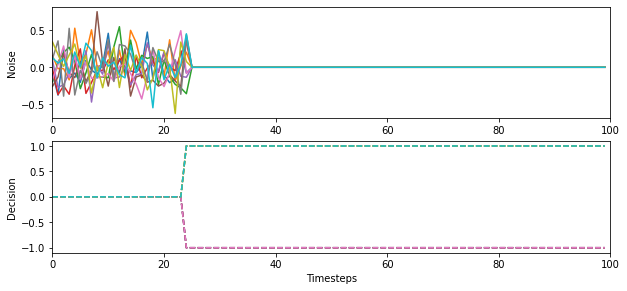

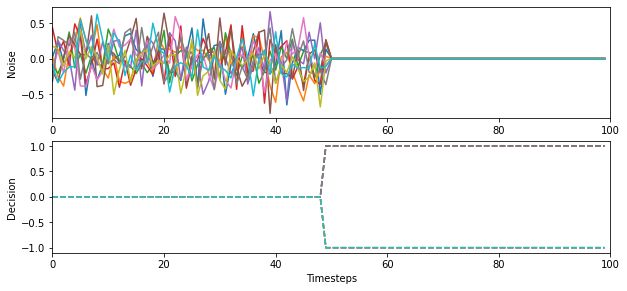

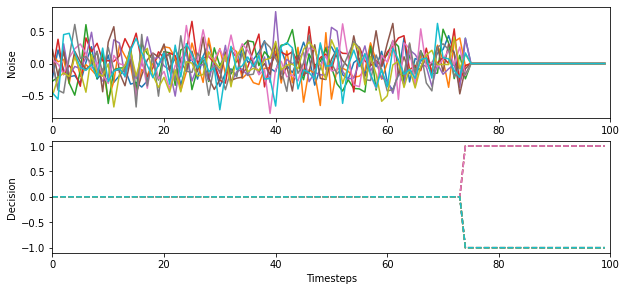

In [67]:
# Integration parameters
T = 1.0          # Arbitrary amount time, roughly physiological.
ntimesteps = 100  # Divide T into this many bins
bval = 0.01      # bias value limit
sval = 0.025     # standard deviation (before dividing by sqrt(dt))
input_params = (bval, sval, T, ntimesteps)

seed = onp.random.randint(0, 1000000) # get randomness from CPU level numpy
#print("Seed: %d" % seed)
key = random.PRNGKey(seed) # create a random key for jax for use on device.

# Plot a few input/target examples to make sure things look sane.
ntoplot = 10    # how many examples to plot
key, skey = random.split(key, 2)
skeys = random.split(skey, ntoplot) # get ntoplot random keys
inputs1, targets1,_ = build_inputs_and_targets_jit1(input_params, skeys)
inputs2, targets2,_ = build_inputs_and_targets_jit2(input_params, skeys)
inputs3, targets3,_ = build_inputs_and_targets_jit3(input_params, skeys)
# Plot the input to the RNN and the target for the RNN.
plot_batch(ntimesteps, inputs1, targets1)
plot_batch(ntimesteps, inputs2, targets2)
plot_batch(ntimesteps, inputs3, targets3)

####New input

In [56]:
"""Routines for creating white noise and integrated white noise."""
def build_input_and_target_pure_integration1(input_params, key):
  
  bias_val, stddev_val, T, Ntime = input_params
  dt = T/Ntime
  ntime = int(Ntime/3)

  # Create the white noise input.
  key, skeys = keygen(key, 2)
  random_sample = random.normal(next(skeys), (1,))[0]
  bias = bias_val * 2.0 * (random_sample - 0.5)
  stddev = stddev_val / np.sqrt(dt)
  random_samples = random.normal(next(skeys), (ntime,))
  noise_t = stddev * random_samples
  white_noise_t = bias + noise_t
  white_noise_t = np.pad(white_noise_t, (0, 2*ntime), 'constant')

  pure_integration_t = np.cumsum(white_noise_t)
  decision = 2.0*((pure_integration_t[24] > 0.0)-0.5)
  targets_t1 = np.zeros(pure_integration_t.shape[0])
  targets_t2 = np.ones(pure_integration_t.shape[0])
  targets_t = np.concatenate([targets_t1[:ntime-1],
                              np.array([decision], dtype=float), decision*targets_t2[ntime:]], axis=0)
  
  initial_constant = np.zeros(5)
  white_noise_t = np.concatenate([initial_constant,
                              white_noise_t], axis=0)
  
  inputs_tx1 = np.expand_dims(white_noise_t, axis=1)
  targets_tx1 = np.expand_dims(targets_t, axis=1)
  target_mask = np.array([ntime-1]) # When target is defined.
  print('targetMask', target_mask)
  return inputs_tx1, targets_tx1, target_mask

def build_input_and_target_pure_integration2(input_params, key):
  bias_val, stddev_val, T, ntime = input_params
  dt = T/ntime
  ntime = int(2*ntime/3)
  # Create the white noise input.
  key, skeys = keygen(key, 2)
  random_sample = random.normal(next(skeys), (1,))[0]
  bias = bias_val * 2.0 * (random_sample - 0.5)
  stddev = stddev_val / np.sqrt(dt)
  random_samples = random.normal(next(skeys), (ntime,))
  noise_t = stddev * random_samples
  white_noise_t = bias + noise_t
  
  white_noise_t = np.pad(white_noise_t, (0, 25), 'constant')
  pure_integration_t = np.cumsum(white_noise_t)
  decision = 2.0*((pure_integration_t[ntime-1] > 0.0)-0.5)
  targets_t1 = np.zeros(pure_integration_t.shape[0])
  targets_t2 = np.ones(pure_integration_t.shape[0])
  targets_t = np.concatenate([targets_t1[:ntime-1],
                              np.array([decision], dtype=float), decision*targets_t2[ntime:]], axis=0)
  
  initial_constant = np.zeros(2*5)
  white_noise_t = np.concatenate([initial_constant,
                              white_noise_t], axis=0)
  
  inputs_tx1 = np.expand_dims(white_noise_t, axis=1)
  targets_tx1 = np.expand_dims(targets_t, axis=1)
  target_mask = np.array([ntime-1]) # When target is defined.
  print('targetMask', target_mask)
  return inputs_tx1, targets_tx1, target_mask

def build_input_and_target_pure_integration3(input_params, key):
  bias_val, stddev_val, T, ntime = input_params
  dt = T/ntime
  # Create the white noise input.
  key, skeys = keygen(key, 2)
  random_sample = random.normal(next(skeys), (1,))[0]
  bias = bias_val * 2.0 * (random_sample - 0.5)
  stddev = stddev_val / np.sqrt(dt)
  random_samples = random.normal(next(skeys), (ntime,))
  noise_t = stddev * random_samples
  white_noise_t = bias + noise_t
  #print(white_noise_t.shape)

  # * dt, intentionally left off to get output scaling in O(1).
  pure_integration_t = np.cumsum(white_noise_t)
  #print('pure', pure_integration_t[-1])
  decision = 2.0*((pure_integration_t[-1] > 0.0)-0.5)
  targets_t = np.zeros(pure_integration_t.shape[0]-1)
  targets_t = np.concatenate([targets_t,
                              np.array([decision], dtype=float)], axis=0)
  
  initial_constant = np.zeros(3*5)
  white_noise_t = np.concatenate([initial_constant,
                              white_noise_t], axis=0)
  
  inputs_tx1 = np.expand_dims(white_noise_t, axis=1)
  targets_tx1 = np.expand_dims(targets_t, axis=1)
  target_mask = np.array([ntime-1]) # When target is defined.
  print('targetMask', target_mask)
  return inputs_tx1, targets_tx1, target_mask
  
# Now batch it and jit.
build_input_and_target1 = build_input_and_target_pure_integration1
build_input_and_target2 = build_input_and_target_pure_integration2
build_input_and_target3 = build_input_and_target_pure_integration3

build_inputs_and_targets1 = vmap(build_input_and_target1, in_axes=(None, 0))
build_inputs_and_targets2 = vmap(build_input_and_target2, in_axes=(None, 0))
build_inputs_and_targets3 = vmap(build_input_and_target3, in_axes=(None, 0))

build_inputs_and_targets_jit1 = jit(build_inputs_and_targets1,
                                   static_argnums=(0,))
build_inputs_and_targets_jit2 = jit(build_inputs_and_targets2,
                                   static_argnums=(0,))
build_inputs_and_targets_jit3 = jit(build_inputs_and_targets3,
                                   static_argnums=(0,))

def plot_batch(ntimesteps, input_bxtxu, target_bxtxo=None, output_bxtxo=None,
               errors_bxtxo=None):
  """Plot some white noise / integrated white noise examples."""
  ntoplot = 10
  plt.figure(figsize=(10,7))
  plt.subplot(311)
  plt.plot(input_bxtxu[0:ntoplot,:,0].T)
  #plt.xlim([-15, ntimesteps-1])
  
  plt.xticks(onp.arange(0, 95, 5), onp.arange(-15,75, 5))
  plt.ylabel('Noise')
  plt.subplot(312)
  if output_bxtxo is not None:
    plt.plot(output_bxtxo[0:ntoplot,:,0].T, label = 'Predicted value');
    plt.xlim([0, ntimesteps-1]);
  if target_bxtxo is not None:
    plt.plot(target_bxtxo[0:ntoplot,:,0].T, '--',label = 'True value');
    plt.xlim([0, ntimesteps-1]);
    plt.ylabel("Decision")
  if errors_bxtxo is not None:
    plt.subplot(313)
    plt.plot(errors_bxtxo[0:ntoplot,:,0].T, '--');
    plt.xlim([0, ntimesteps-1]);
    plt.ylabel("|Errors|")
  plt.xlabel('Timesteps')

####Hyperparameters

In [68]:
# Integrator RNN hyperparameters
u = 1         # Number of inputs to the RNN
n = 200       # Number of units in the RNN
o = 1         # Number of outputs in the RNN
param_scale = 0.85 # Scaling of the recurrent weight matrix

# Optimization hyperparameters
num_batchs = 10000        # Total number of batches to train on.
batch_size = 512          # How many examples in each batch
eval_batch_size = 1024    # How large a batch for evaluating the RNN
step_size = 0.025          # initial learning rate
decay_factor = 0.99975     # decay the learning rate this much
# Gradient clipping is HUGELY important for training RNNs
max_grad_norm = 10.0      # max gradient norm before clipping, clip to this value.
l2reg = 0.0002           # amount of L2 regularization on the weights
adam_b1 = 0.9             # Adam parameters
adam_b2 = 0.999
adam_eps = 1e-1
print_every = 1000          # Print training informatino every so often

## Create a decay function for the learning rate
decay_fun = optimizers.exponential_decay(step_size, decay_steps=1, 
                                         decay_rate=decay_factor)
batch_idxs = onp.linspace(1, num_batchs)
# Init some parameters for training.
key, subkey = random.split(key, 2)
init_params = random_vrnn_params(subkey, u, n, o, g=param_scale)

####Training

In [ ]:
# Initialize the optimizer.  Please see jax/experimental/optimizers.py
opt_init, opt_update, get_params = optimizers.adam(decay_fun, adam_b1, adam_b2, adam_eps)
opt_state = opt_init(init_params)

# Run the optimization loop, first jit'd call will take a minute.
start_time = time.time()
all_train_losses = []

for batch in range(num_batchs):
    key, subkey = random.split(key, 2)
    skeys = random.split(subkey, int(batch_size/3))

    inputs1, targets1,target_mask1 = build_inputs_and_targets_jit1(input_params, skeys)
    inputs2, targets2,target_mask2 = build_inputs_and_targets_jit2(input_params, skeys)
    inputs3, targets3,target_mask3 = build_inputs_and_targets_jit3(input_params, skeys)

    inputs = np.vstack((inputs1, inputs2, inputs3))
    targets = np.vstack((targets1, targets2, targets3))
    target_masks = np.vstack((target_mask1, target_mask2, target_mask3))
    
    opt_state = update_w_gc_jit(batch, opt_state, opt_update, get_params, inputs,
                                  targets, target_masks, max_grad_norm, l2reg)
    
    if (batch+1) % 1000 == 0:
        params = get_params(opt_state)
        all_train_losses.append(loss_jit(params, inputs, targets,target_masks, l2reg))
        train_loss = all_train_losses[-1]['total']

        batch_time = time.time() - start_time
        step_size = decay_fun(batch)
        s = "Batch {} in {:0.2f} sec, step size: {:0.5f},training loss {:0.4f}"
        print(s.format(batch, batch_time, step_size, train_loss))
        start_time = time.time()    
# List of dicts to dict of lists
all_train_losses = {k: [dic[k] for dic in all_train_losses] for k in all_train_losses[0]}

Testing

In [ ]:
# Take a batch for an evalulation loss, notice the L2 penalty is 0
# for the evaluation.
params = get_params(opt_state)

key, subkey = random.split(key, 2)
skeys = random.split(subkey, int(batch_size/3))
inputs1, targets1,target_mask1 = build_inputs_and_targets_jit1(input_params, skeys)
inputs2, targets2,target_mask2 = build_inputs_and_targets_jit2(input_params, skeys)
inputs3, targets3,target_mask3 = build_inputs_and_targets_jit3(input_params, skeys)

inputs = np.vstack((inputs1, inputs2, inputs3))
targets = np.vstack((targets1, targets2, targets3))
target_masks = np.vstack((target_mask1, target_mask2, target_mask3))

eval_loss = loss_jit(params, inputs, targets, target_masks, l2reg=0.0)['total']
eval_loss_str = "{:.5f}".format(eval_loss)
print("Loss on a new large batch: %s" % (eval_loss_str))

Loss on a new large batch: 0.04353


Visualizations of trained system

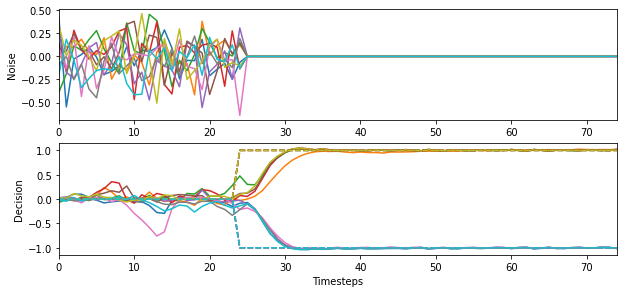

In [ ]:
# Visualize how good this trained integrator is
def inputs_targets_no_h0s(keys):
    inputs_b, targets_b, masks_b = build_inputs_and_targets_jit1(input_params, keys)
    h0s_b = None # Use trained h0
    masks_b = None #Not used
    return inputs_b, targets_b, masks_b, h0s_b

rnn_run = lambda inputs1: batched_rnn_run(params, inputs1)
give_trained_h0 = lambda batch_size : np.array([params['h0']] * batch_size)

T = 1.0         # Arbitraty amount time, roughtly physiological
ntimesteps = 75
input_params = (bval, sval, T, ntimesteps)
nexamples = 3000

rnn_internals = run_trials(rnn_run, inputs_targets_no_h0s, 1, nexamples)

plot_batch(ntimesteps, rnn_internals['inputs'], 
          rnn_internals['targets'], rnn_internals['outputs'])

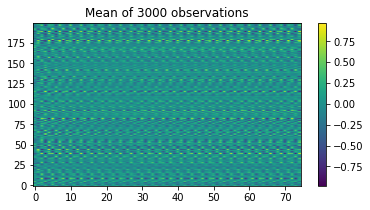

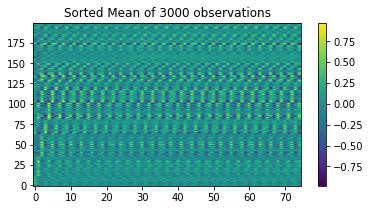

In [ ]:
H = rnn_internals['hiddens']
h = H[0,:,:]
for i in range(1,nexamples):
  h += H[i,:,:] 
ht = h.T/nexamples

fig = plt.figure(figsize=(6, 3))
ax = fig.add_subplot()
heatmap = ax.imshow(ht, origin = 'lower', aspect= 'auto')
ax.set_title('Mean of 3000 observations')
cbar = plt.colorbar(heatmap)
plt.show()

time_location = []
for j in range(n):
  postn = onp.argmax(ht[j,:])
  time_location.append(postn)
time_location = np.array(time_location)

Idx = np.argsort(time_location)
A = ht[Idx,:]

fig = plt.figure(figsize=(6, 3))
ax = fig.add_subplot()
heatmap = ax.imshow(A, origin = 'lower', aspect= 'auto')
ax.set_title('Sorted Mean of 3000 observations')
cbar = plt.colorbar(heatmap) 

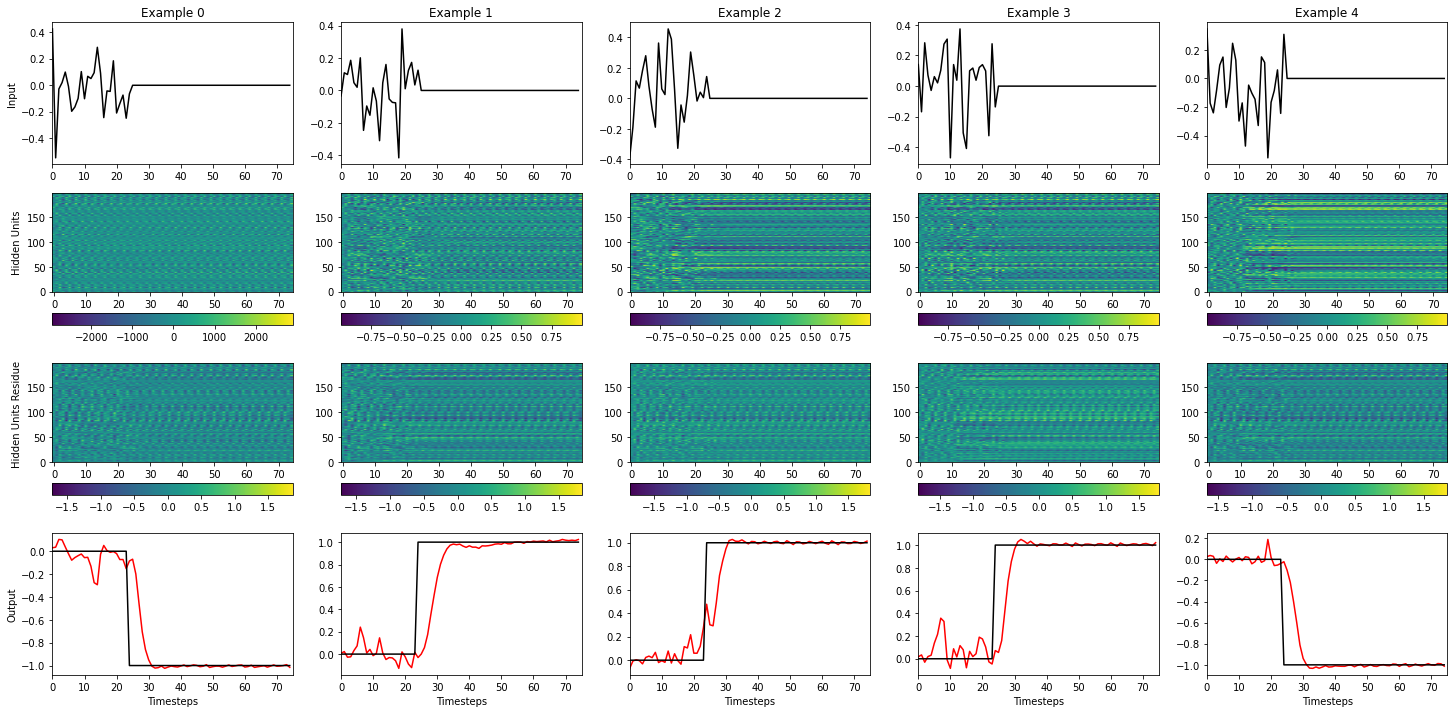

In [ ]:
def plot_examples_residuals(ntimesteps, rnn_internals, nexamples=1):
  """Plot some input/hidden/output triplets."""
  plt.figure(figsize=(nexamples*5, 12))
  row = 4
  for bidx in range(nexamples):
    plt.subplot(row, nexamples, bidx+1)
    plt.plot(rnn_internals['inputs'][bidx,:], 'k')
    plt.xlim([0, ntimesteps])
    plt.title('Example %d' % (bidx))
    if bidx == 0:
      plt.ylabel('Input')
      
  ntoplot = 10
  for bidx in range(nexamples):
    plt.subplot(row, nexamples, nexamples+bidx+1)
    heatmap = plt.imshow(rnn_internals['hiddens'][bidx, :, :].T, origin = 'lower', aspect= 'auto')
    cbar = plt.colorbar(heatmap, orientation='horizontal') 
    if bidx == 0:
      plt.ylabel('Hidden Units')

  for bidx in range(nexamples):
    plt.subplot(row, nexamples, 2*nexamples+bidx+1)
    heatmap = plt.imshow(rnn_internals['hiddens'][bidx+1, :, :].T - A, origin = 'lower', aspect= 'auto')
    cbar = plt.colorbar(heatmap, orientation='horizontal') 
    if bidx == 0:
      plt.ylabel('Hidden Units Residue ')

  for bidx in range(nexamples):
    plt.subplot(row, nexamples, 3*nexamples+bidx+1)
    plt.plot(rnn_internals['outputs'][bidx,:,:], 'r')
    plt.plot(rnn_internals['targets'][bidx,:,:], 'k')    
    plt.xlim([0, ntimesteps])
    plt.xlabel('Timesteps')
    if bidx == 0:
      plt.ylabel('Output')

# Visualize the hidden state, as an example.
plot_examples_residuals(ntimesteps, rnn_internals, nexamples=5)

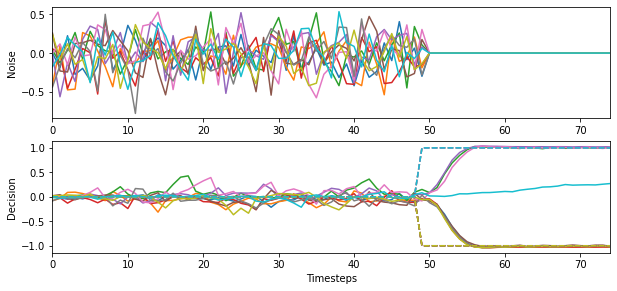

In [ ]:
# Visualize how good this trained integrator is
def inputs_targets_no_h0s(keys):
    inputs_b, targets_b, masks_b = build_inputs_and_targets_jit2(input_params, keys)
    h0s_b = None # Use trained h0
    masks_b = None #Not used
    return inputs_b, targets_b, masks_b, h0s_b

rnn_run = lambda inputs: batched_rnn_run(params, inputs)
give_trained_h0 = lambda batch_size : np.array([params['h0']] * batch_size)

T = 1.0         # Arbitraty amount time, roughtly physiological
ntimesteps = 75
input_params = (bval, sval, T, ntimesteps)
nexamples = 40

rnn_internals = run_trials(rnn_run, inputs_targets_no_h0s, 1, nexamples)

plot_batch(ntimesteps, rnn_internals['inputs'], 
          rnn_internals['targets'], rnn_internals['outputs'])

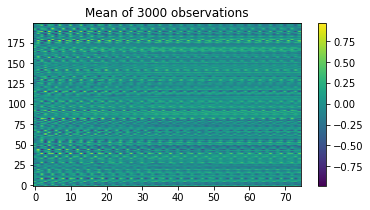

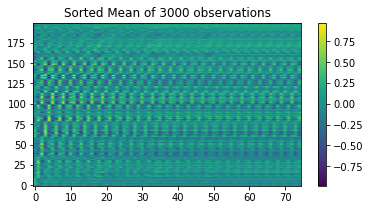

In [ ]:
H = rnn_internals['hiddens']
h = H[0,:,:]
for i in range(1,nexamples):
  h += H[i,:,:] 
ht = h.T/nexamples

fig = plt.figure(figsize=(6, 3))
ax = fig.add_subplot()
heatmap = ax.imshow(ht, origin = 'lower', aspect= 'auto')
ax.set_title('Mean of 3000 observations')
cbar = plt.colorbar(heatmap) 
plt.show()


time_location = []
for j in range(n):
  postn = onp.argmax(ht[j,:])
  time_location.append(postn)
time_location = np.array(time_location)

Idx = np.argsort(time_location)
A = ht[Idx,:]

fig = plt.figure(figsize=(6, 3))
ax = fig.add_subplot()
heatmap = ax.imshow(A, origin = 'lower', aspect= 'auto')
ax.set_title('Sorted Mean of 3000 observations')
cbar = plt.colorbar(heatmap) 

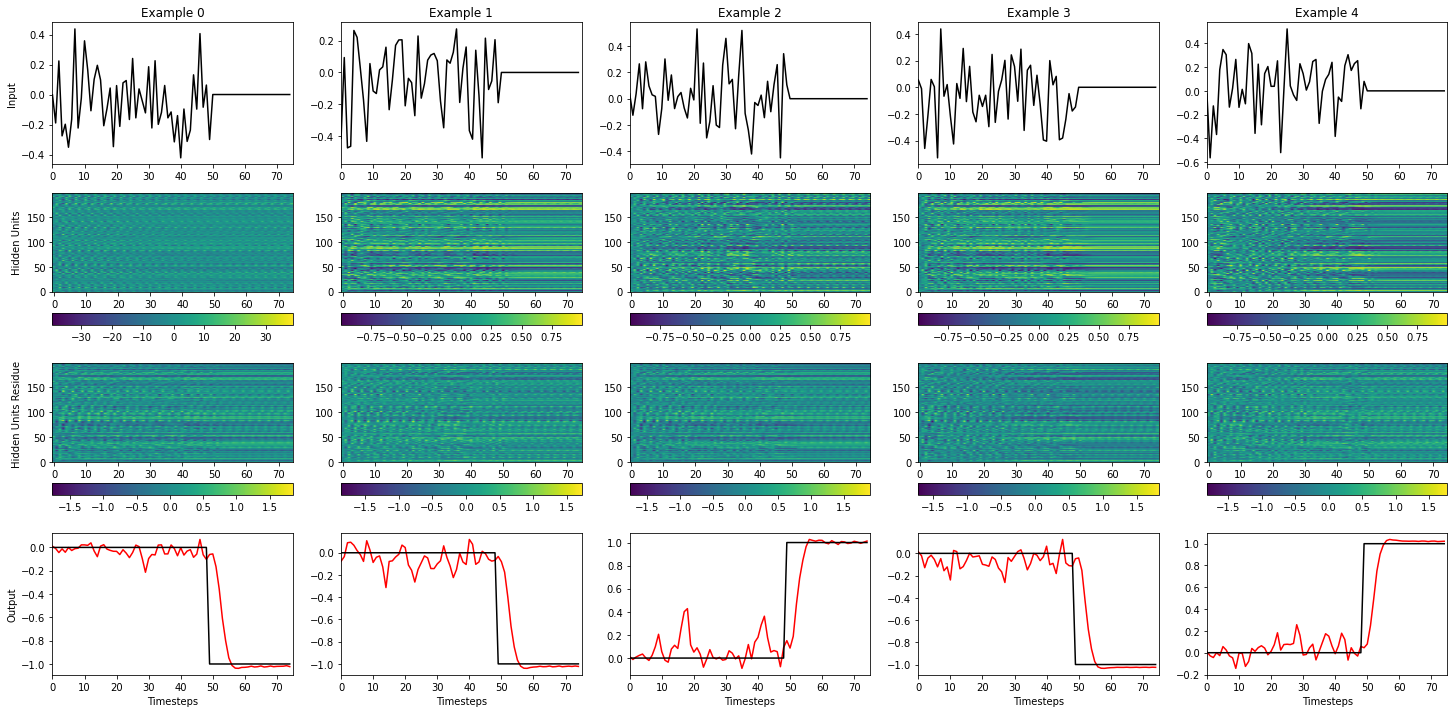

In [ ]:
def plot_examples_residuals(ntimesteps, rnn_internals, nexamples=1):
  """Plot some input/hidden/output triplets."""
  plt.figure(figsize=(nexamples*5, 12))
  row = 4
  for bidx in range(nexamples):
    plt.subplot(row, nexamples, bidx+1)
    plt.plot(rnn_internals['inputs'][bidx,:], 'k')
    plt.xlim([0, ntimesteps])
    plt.title('Example %d' % (bidx))
    if bidx == 0:
      plt.ylabel('Input')
      
  ntoplot = 10
  for bidx in range(nexamples):
    plt.subplot(row, nexamples, nexamples+bidx+1)
    heatmap = plt.imshow(rnn_internals['hiddens'][bidx, :, :].T, origin = 'lower', aspect= 'auto')
    cbar = plt.colorbar(heatmap, orientation='horizontal') 
    if bidx == 0:
      plt.ylabel('Hidden Units')

  for bidx in range(nexamples):
    plt.subplot(row, nexamples, 2*nexamples+bidx+1)
    heatmap = plt.imshow(rnn_internals['hiddens'][bidx+1, :, :].T - A, origin = 'lower', aspect= 'auto')
    cbar = plt.colorbar(heatmap, orientation='horizontal') 
    if bidx == 0:
      plt.ylabel('Hidden Units Residue ')

  for bidx in range(nexamples):
    plt.subplot(row, nexamples, 3*nexamples+bidx+1)
    plt.plot(rnn_internals['outputs'][bidx,:,:], 'r')
    plt.plot(rnn_internals['targets'][bidx,:,:], 'k')    
    plt.xlim([0, ntimesteps])
    plt.xlabel('Timesteps')
    if bidx == 0:
      plt.ylabel('Output')

# Visualize the hidden state, as an example.
plot_examples_residuals(ntimesteps, rnn_internals, nexamples=5)

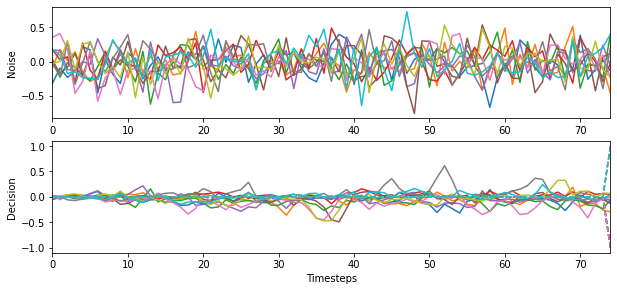

In [ ]:
# Visualize how good this trained integrator is
def inputs_targets_no_h0s(keys):
    inputs_b, targets_b, masks_b = build_inputs_and_targets_jit3(input_params, keys)
    h0s_b = None # Use trained h0
    masks_b = None #Not used
    return inputs_b, targets_b, masks_b, h0s_b

rnn_run = lambda inputs1: batched_rnn_run(params, inputs1)
give_trained_h0 = lambda batch_size : np.array([params['h0']] * batch_size)

T = 1.0         # Arbitraty amount time, roughtly physiological
ntimesteps = 75
input_params = (bval, sval, T, ntimesteps)
nexamples = 40

rnn_internals = run_trials(rnn_run, inputs_targets_no_h0s, 1, nexamples)

plot_batch(ntimesteps, rnn_internals['inputs'], 
          rnn_internals['targets'], rnn_internals['outputs'])

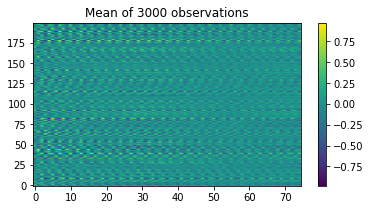

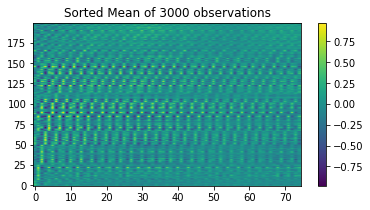

In [ ]:
H = rnn_internals['hiddens']
h = H[0,:,:]
for i in range(1,nexamples):
  h += H[i,:,:] 
ht = h.T/nexamples

fig = plt.figure(figsize=(6, 3))
ax = fig.add_subplot()
heatmap = ax.imshow(ht, origin = 'lower', aspect= 'auto')
ax.set_title('Mean of 3000 observations')
cbar = plt.colorbar(heatmap) 
plt.show()


time_location = []
for j in range(n):
  postn = onp.argmax(ht[j,:])
  time_location.append(postn)
time_location = np.array(time_location)

Idx = np.argsort(time_location)
A = ht[Idx,:]

fig = plt.figure(figsize=(6, 3))
ax = fig.add_subplot()
heatmap = ax.imshow(A, origin = 'lower', aspect= 'auto')
ax.set_title('Sorted Mean of 3000 observations')
cbar = plt.colorbar(heatmap) 

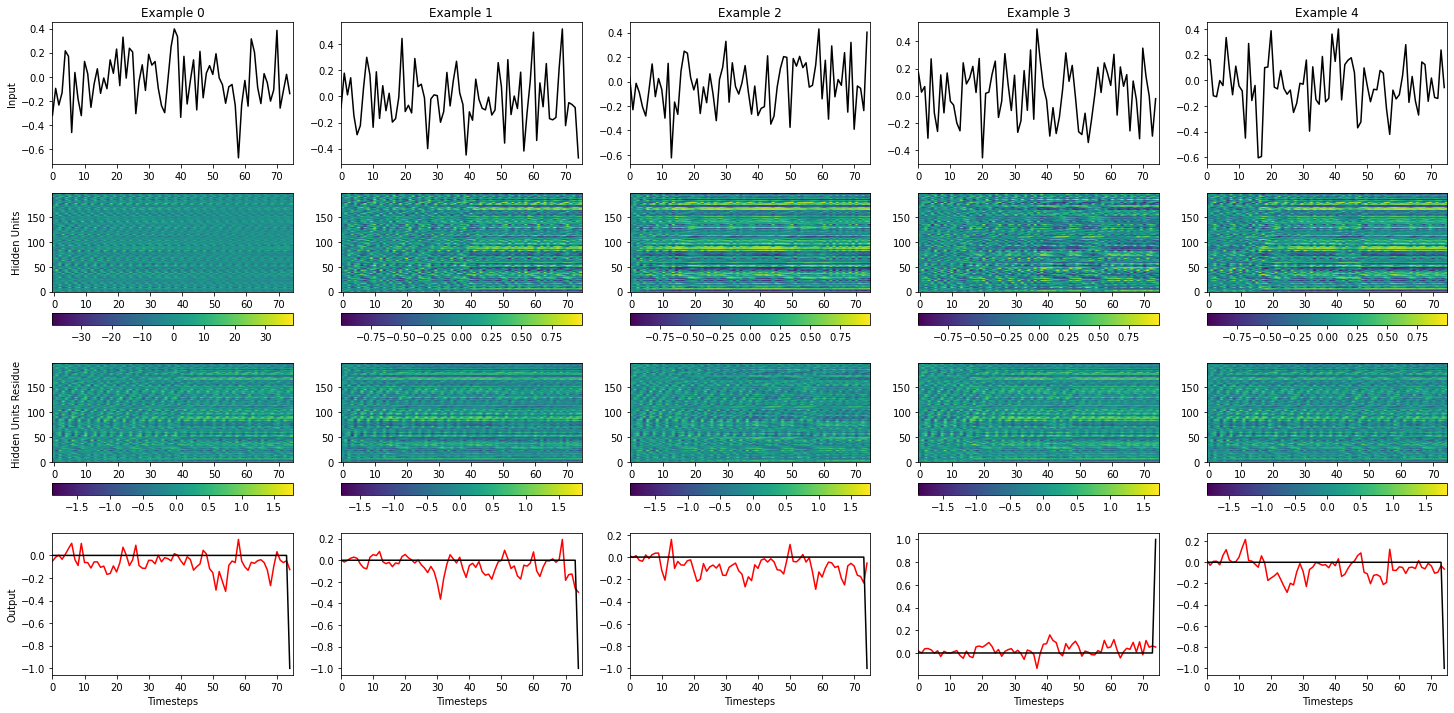

In [ ]:
def plot_examples_residuals(ntimesteps, rnn_internals, nexamples=1):
  """Plot some input/hidden/output triplets."""
  plt.figure(figsize=(nexamples*5, 12))
  row = 4
  for bidx in range(nexamples):
    plt.subplot(row, nexamples, bidx+1)
    plt.plot(rnn_internals['inputs'][bidx,:], 'k')
    plt.xlim([0, ntimesteps])
    plt.title('Example %d' % (bidx))
    if bidx == 0:
      plt.ylabel('Input')
      
  ntoplot = 10
  for bidx in range(nexamples):
    plt.subplot(row, nexamples, nexamples+bidx+1)
    heatmap = plt.imshow(rnn_internals['hiddens'][bidx, :, :].T, origin = 'lower', aspect= 'auto')
    cbar = plt.colorbar(heatmap, orientation='horizontal') 
    if bidx == 0:
      plt.ylabel('Hidden Units')

  for bidx in range(nexamples):
    plt.subplot(row, nexamples, 2*nexamples+bidx+1)
    heatmap = plt.imshow(rnn_internals['hiddens'][bidx+1, :, :].T - A, origin = 'lower', aspect= 'auto')
    cbar = plt.colorbar(heatmap, orientation='horizontal') 
    if bidx == 0:
      plt.ylabel('Hidden Units Residue ')

  for bidx in range(nexamples):
    plt.subplot(row, nexamples, 3*nexamples+bidx+1)
    plt.plot(rnn_internals['outputs'][bidx,:,:], 'r')
    plt.plot(rnn_internals['targets'][bidx,:,:], 'k')    
    plt.xlim([0, ntimesteps])
    plt.xlabel('Timesteps')
    if bidx == 0:
      plt.ylabel('Output')

# Visualize the hidden state, as an example.
plot_examples_residuals(ntimesteps, rnn_internals, nexamples=5)